In [ ]:
import os
import sys
from typing import Optional, Any

from dotenv import load_dotenv, find_dotenv
import numpy as np

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate

/Users/aditya/anaconda3/envs/mini/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# make sure GOOGLE_API_KEY (or any other llm provider, must exactly the same)
_ = load_dotenv(find_dotenv())
# or put it into variable and pass it to llm model 
# google_api_key = os.getenv('GOOGLE_API_KEY') # pass this to the model creation

# Agent Concept

![](../media/agent_tools.png)

What is an AI Agent? 
An AI agent is a program that uses a language model to understand a task and decide the best way to complete it using available tools autonomously.
A key idea in AI agents is the set of **Tools** (functions) they can use to get the job done. 
For each request, the AI plans the best approach, deciding what steps and tools are needed and in what order to complete the task.

For this example, we will create an Agent that could get the weather from external API, either by specify the location/city or by trying to use current location.

In [28]:
"""
agent that we use as example:
    1. get weather
    2. get location (dummy, returning random between Jakarta, Seoul, Tokyo)
"""
from datetime import datetime
import zoneinfo as zi
import requests
from langchain_core.tools import BaseTool
from langchain_core.tools import Tool, tool, StructuredTool
from pydantic import BaseModel, Field
from typing import Type, Optional
import random

class Location(BaseModel):
    location: str = Field(description='Location to find weather')
    
@tool
def get_weather(location: Optional[str]='Jakarta') -> str:
    """Get the weather via API in a location (provided, Jakarta as default).
    A tool designed to gather accurate information on weather around the globe. 
    Useful for when you need to answer questions about the weather. 
    Input should be the location.
    """
    WEATHERAPI_API_KEY='8a6c94f591c4401c9e8152836251301'
    res = requests.get(f'https://api.weatherapi.com/v1/current.json?key={WEATHERAPI_API_KEY}&q={location}&aqi=no')
    return "For {} temperature: {:.2F} and weather: {}".format(
        location,
        res.json()['current']['temp_c'],
        res.json()['current']['condition']['text']
        )
@tool
def get_current_location() -> str:
    """
    Get the current location of a user (approxmate).
    Input: None
    Output: City name 
    """

    random_city = ['Jakarta', 'Seoul', 'Tokyo', 'Singapore', 'Kuala Lumpur']
    return random.choice(random_city)

The function is a tool already (after using decorator). In order to test the tool, call `.run()` method.

In [29]:
get_weather.run('Jakarta')

'For Jakarta temperature: 31.00 and weather: Partly cloudy'

In [30]:
get_current_location.run({})

'Jakarta'

Use langgraph function to create a react agent (stands for Reasoning and Action agent). On a high level, given a query, the model will [be](https://www.leewayhertz.com/react-agents-vs-function-calling-agents/):
1. Break down the task into smaller step, choosing the required tools
2. Exceute the step based on the tools
3. Observe the result (should it use another tools or return the answer)
4. Give response


In [20]:
from langgraph.prebuilt import create_react_agent

# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm = ChatGroq(model="gemma2-9b-it", api_key=os.getenv('GROQ_API_KEY'))
# query = "How's the weather in Jakarta?"
# query = "What's my current location, and what's the temperature?"
system_prompt = "You are a helpful assistant that provides information about the weather. Please answer in Bahasa."
query = "What's the temperature on my current location?" # the agent is smart enough to call the get_location tools first, before pass it to the get_weather tools
agent_executor = create_react_agent(model=llm, tools=[get_weather, get_current_location], state_modifier=system_prompt)
message = agent_executor.invoke({
    'messages': [
        ('human', query)
    ]
})
message['messages'][-1].content

'Suhu di Tokyo adalah 14.10 derajat dan cuaca sedang berawan. \n'

## Saving Checkpoint

Langgraph provides a way to save a chat session by having thread_id. 

In [21]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

agent_executor = create_react_agent(model=llm, tools=[get_weather, get_current_location], state_modifier=system_prompt, checkpointer=memory)

# create configuration for Thread Id
config = {"configurable": {"thread_id": "test-thread"}}
message = agent_executor.invoke({
    'messages': [
        ('human', query)
    ]},
    config
)

In [22]:
message['messages'][-1]

AIMessage(content='Untuk Tokyo, suhu saat ini adalah 14.10 derajat dan cuaca sedang sebagian berawan.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1283, 'total_tokens': 1308, 'completion_time': 0.045454545, 'prompt_time': 0.095660873, 'queue_time': 0.021494276000000007, 'total_time': 0.141115418}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-44fb73e0-553e-4562-80ae-99a50426f2ef-0', usage_metadata={'input_tokens': 1283, 'output_tokens': 25, 'total_tokens': 1308})

In [23]:
m = agent_executor.invoke({
    'messages': [
        ('human', 'What is the city that I ask previously?')
    ]},
    config
)

In [24]:
m['messages'][-1]

AIMessage(content='Tokyo \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 1325, 'total_tokens': 1330, 'completion_time': 0.009090909, 'prompt_time': 0.056883411, 'queue_time': 0.019269293, 'total_time': 0.06597432}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-1d02ef23-112f-4003-8229-d87fcd620fb3-0', usage_metadata={'input_tokens': 1325, 'output_tokens': 5, 'total_tokens': 1330})

## Display Graph

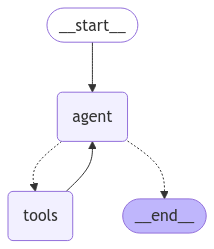

In [11]:
from IPython.display import Image, display

try:
    display(Image(agent_executor.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# From Scratch

In [38]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Define the state
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
tools = [get_weather, get_current_location]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    messages = state["messages"]
    system_prompt_message = SystemMessage(content=system_prompt)
    inputs = [system_prompt_message] + messages
    return {"messages": [llm_with_tools.invoke(inputs)]}
    # return {"messages": [llm_with_tools.invoke(messages)]}

graph_builder.add_node("chatbot", chatbot)

In [39]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)


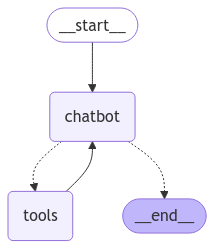

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
answer = graph.invoke(
    {
        "messages": [("human", "What's the temperature on my current location?")]
    }, 
    {"configurable": {"thread_id": 42}}
)

In [42]:
answer

{'messages': [HumanMessage(content="What's the temperature on my current location?", additional_kwargs={}, response_metadata={}, id='99c03dde-c14e-4d84-803e-4b18fee7cebe'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3v1t', 'function': {'arguments': '{}', 'name': 'get_current_location'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1126, 'total_tokens': 1199, 'completion_time': 0.132727273, 'prompt_time': 0.039282914, 'queue_time': 0.020739282999999997, 'total_time': 0.172010187}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d22bdd86-4959-4241-8b75-796177584419-0', tool_calls=[{'name': 'get_current_location', 'args': {}, 'id': 'call_3v1t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1126, 'output_tokens': 73, 'total_tokens': 1199}),
  ToolMessage(content='Singapore', name='get_current_location', id='23c75c09-42af-

In [43]:
answer["messages"][-1].content

'Suhu di lokasi kamu saat ini adalah 30.10 derajat Celcius dengan kondisi sebagian awan.  \n'

In [44]:
answer = graph.invoke(
    {
        "messages": [("human", "What is previous location?")]
    }, 
    {"configurable": {"thread_id": 42}}
)

In [45]:
answer

{'messages': [HumanMessage(content="What's the temperature on my current location?", additional_kwargs={}, response_metadata={}, id='99c03dde-c14e-4d84-803e-4b18fee7cebe'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3v1t', 'function': {'arguments': '{}', 'name': 'get_current_location'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1126, 'total_tokens': 1199, 'completion_time': 0.132727273, 'prompt_time': 0.039282914, 'queue_time': 0.020739282999999997, 'total_time': 0.172010187}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d22bdd86-4959-4241-8b75-796177584419-0', tool_calls=[{'name': 'get_current_location', 'args': {}, 'id': 'call_3v1t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1126, 'output_tokens': 73, 'total_tokens': 1199}),
  ToolMessage(content='Singapore', name='get_current_location', id='23c75c09-42af-